<a href="https://colab.research.google.com/github/mkorlyakova/Time-Series-Prediction/blob/master/Test_Time_series_PJME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install modul


In [44]:
!pip install holidays

Import all progect modules

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")



In [46]:
import os
#os.system("pip install holidays")
import holidays

In [47]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import timedelta
one_hours = timedelta(hours=1)
one_day = timedelta(days=1)

In [48]:
from sklearn.linear_model import LinearRegression

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score



In [50]:
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM


from tensorflow.keras.callbacks import EarlyStopping

In [51]:

import pickle

1. Читаем  данные

In [52]:
!git clone -l -s https://github.com/mkorlyakova/Time-Series-Prediction.git cloned-repo

!ls

fatal: destination path 'cloned-repo' already exists and is not an empty directory.
cloned-repo  sample_data


Читаем данные в память - причесываем немного и берем для работы 1-й столбец (остальные можно было бы убрать)

In [53]:
Path = '/content/cloned-repo/'
Path_Energy = '/content/cloned-repo/PJME_hourly.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])


data.sort_index(inplace=True)
#data.drop('Time',axis=1, inplace =True)
data.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


# Функции для эксплуатации модели

In [54]:

#добавляем историю длиной р

p =24*7 # будем смотреть на 7 дней назад
h = 24 #предскажем на 24 часа вперед

In [55]:

def neuro_net(inputs_shape=[1,1,1], lstmlist=[8],convlist=[32,32],denselist=[3]):
  model = Sequential()
  model.add(LSTM(lstmlist[0], input_shape = (inputs_shape[1], inputs_shape[2]), return_sequences="True"))
  if len(lstmlist)==2 :
    model.add(LSTM(lstmlist[1], return_sequences="True"))
  for conv in convlist:
    model.add(Conv1D(conv, 3, activation="linear"))
  
  model.add(Flatten())
  for dens_i in denselist:
    model.add(Dense(dens_i, activation="linear"))
  model.add(Dense(1, activation="linear"))
  model.compile(loss="mse", optimizer="adam", metrics=['mae'])
  return model

callback = EarlyStopping(monitor='val_mae', patience=3)

Используем модель:
- строю функцию для обработки признаков для любого куска исходного ряда
- проверяю модель

In [56]:
def feature_make(data,path):
  # clear data
  data['date']=data.index
  data_time_h = pd.date_range(data.index[0],data.index[-1],freq='H')

  time_lost = np.where(np.isin(data_time_h.values, data['date'].values)==False)
  # calculate lost value of consumption
  v = np.round((data.loc[data_time_h[time_lost]-one_hours]['PJME_MW'].values+data.loc[data_time_h[time_lost]+one_hours]['PJME_MW'].values)/2).reshape(-1,1)
  df_data = pd.DataFrame(data = v, index=data_time_h[time_lost],columns=['PJME_MW'])
  df_data['date']=data_time_h[time_lost]

  # conect data and df_data
  data=pd.concat([data,df_data],join = 'inner')
  data.sort_index(inplace=True)
  data.drop_duplicates(inplace=True)

  #New features

  data['year'] = data['date'].dt.year
  data['month'] = data['date'].dt.month
  data['dayofmonth'] = data['date'].dt.day
  data['quarter'] = data['date'].dt.quarter
  data['dayofyear'] = data['date'].dt.dayofyear
  data['weekofyear'] = data['date'].dt.weekofyear
  data['dayofweek'] = data['date'].dt.dayofweek
  data['hour'] = data['date'].dt.hour
  data.drop( columns = 'date', inplace = True )


  W0,W1 = 32078.642851247627, -0.009399857149792397

  y= data['PJME_MW'].values
  all_data_time_h = pd.date_range('2002-01-01 01:00:00',data.index[-1],freq='H')
  ind = np.where(all_data_time_h == data.index[0] )[0]
  #print(ind[0],all_data_time_h.shape[0])
  x1 = np.array(range(ind[0],all_data_time_h.shape[0]+100))
  y1=W0-W1*x1
  data['PJME_MW no trend'] = y - y1[:y.shape[0]]


  data['d_mov'] = data['PJME_MW'].rolling(window=24).mean()
  data['w_mov'] = data['PJME_MW'].rolling(window=24*7).mean()
  data['y_mov'] = data['PJME_MW'].rolling(window=24*365).mean()

  data['diff1']=data['PJME_MW'].diff(1)

  data.dropna(inplace=True)
  # model parametr
  p=24*7
  h=24
  #print(data.iloc[-h:,:])

  X_Y = data.values
  #print(X_Y.shape)
  filename = path+'final_scaler.sav'
  scl=pickle.load(open(filename, 'rb'))

  X_Y_test = scl.transform(X_Y)

  X_test = X_Y_test[:-h,:]
  Y_test = X_Y_test[h+p:,0]


  batch_size=32

  dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_test[p:,:],
    Y_test,
    sequence_length=p,
    sampling_rate=5,
    batch_size=batch_size)

  return dataset_val, scl


In [57]:
def model_work(data,  path):
  i_s=[32,168,14]
  model_final = neuro_net(inputs_shape=[i_s[0],i_s[1],i_s[2]],lstmlist=[8],convlist=[],denselist=[5])
  model_final.load_weights(path+'model_weight.h5')
  X, scl=feature_make(data,path)

  Y = model_final.predict(X)
  #print(scl.scale_[0],scl.mean_[0],Y)
  return Y*scl.scale_[0]+scl.mean_[0]


# Проверка функций

читаем заново данные из набора PJWE_MW

In [58]:
data_test = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])


data_test.sort_index(inplace=True)
#data.drop('Time',axis=1, inplace =True)
data_test.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


Для теста берем конец данных (оцениваем , то на чем не учили)

In [59]:
t=5
T = 20000

y_work=model_work(data_test.iloc[-T-t:-t], Path)

Формируем истиные данные (кусок из значений)

In [60]:
y_test = data_test.iloc[-T-t-h-1:-T-t-1+h*8,0].values

Отображаем

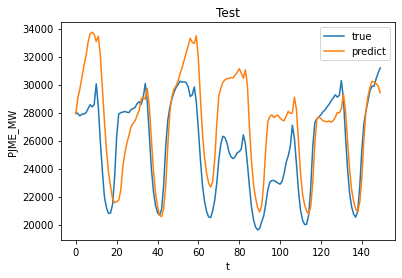

In [61]:
plt.plot(y_test[:150],label='true')
plt.plot(y_work[:150],label='predict')
plt.legend()
plt.title('Test')
plt.ylabel('PJME_MW')
plt.xlabel('t')
plt.show()

Оценка MAPE:

In [62]:
MAPE_y= np.mean(np.abs(y_test[:y_work.shape[0]].reshape(-1,1)-y_work[:,0])/y_work[:,0])*100
print('Ошибка МАРЕ:'+str(MAPE_y)+'%')


Ошибка МАРЕ:19.880110831602053%
